In [1]:
import numpy as np
import pandas as pd
import torch

import warnings
warnings.filterwarnings("ignore")

# Data exploration

In [2]:
df = pd.read_csv("data/CollegeBasketballPlayers2009-2021.csv", low_memory=False)
df

,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
0,DeAndrae Ross,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,...,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,NaN,6.22026
1,Pooh Williams,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,...,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,NaN,3.94375
2,Jesus Verdejo,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,...,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,NaN,10.92680
3,Mike Hornbuckle,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,...,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,NaN,6.77427
4,Anthony Brown,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,...,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61056,Trey Patterson,Villanova,BE,2,0.3,60.5,19.3,0.0,0.00,0.0,...,16.018200,0.0000,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,Pure PG,0.00000
61057,Stavros Polatoglou,Northwestern St.,Slnd,4,1.3,28.3,7.1,0.0,0.00,7.0,...,-4.993820,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.0000,C,0.00000
61058,Sandy Ryan,Tulane,Amer,1,0.1,0.0,0.0,0.0,0.00,0.0,...,-1.126810,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,PF/C,0.00000
61059,Ty Larson,Texas Tech,B12,1,0.1,0.0,0.0,0.0,0.00,0.0,...,-2.380750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,PF/C,0.00000


In [3]:
df.columns

Index(['player_name', 'team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'num', 'porpag', 'adjoe',
       'pfr', 'year', 'pid', 'type', 'Rec Rank', 'ast/tov', 'rimmade',
       'rimmade+rimmiss', 'midmade', 'midmade+midmiss',
       'rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)', 'dunksmade',
       'dunksmiss+dunksmade', 'dunksmade/(dunksmade+dunksmiss)', 'pick',
       'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm',
       'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk',
       'pts', 'Unnamed: 64', 'Unnamed: 65'],
      dtype='object')

### Biranje atributa

U datasetu postoje 66 atributa za svakog igrača, što je previše. Redukcija prostora atributa će biti vršena u tri koraka:

1. Izbacivanje redundantnih atributa.  _Primer_: Odnos asistencija i izgubljenih lopti (`ast/tov`) je suvišan kada već postoje atributi za broj asistencije i broj izgubljenih lopti
2. Izbacivanje atributa na osnovu iskustvenog zananja. _Primer_: Nepotrebno je da pored škole za koju igra student koristimo kao atribut i konferenciju u kojoj je ta škola
3. Nad ostalim atributima će biti izračunata korelacija sa ciljanim izlazima modela, i biće izabrani najboljih 10

Ovim postupkom će model biti manji, i samim tim će mu biti smanjena mogućnost overfittovanja.

Cilj mreže je predviđanje da li će neki pik biti izabran na draftu. Svi odbirci koji imaju vrednost u `pick` koloni biće označeni kao pozitivni, dok će ostali biti označeni kao negativni

In [4]:
# Choose valuable features
clean_df = df[["GP", "Min_per", "usg", "eFG", "TS_per", "ORB_per", "DRB_per", "AST_per", 
               "TO_per", "FT_per", "twoP_per", "TP_per", "blk_per", "stl_per", "porpag", "adjoe", "adrtg", "bpm"]].copy()
clean_df.dropna(inplace=True)

# Calculate target based on if the player was picked in the draft
clean_df["Target"] = df["pick"].copy().fillna(0) > 0

In [56]:
# Describe features
clean_df.describe()

,GP,Min_per,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FT_per,twoP_per,TP_per,blk_per,stl_per,porpag,adjoe,adrtg,bpm
count,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04,6.101600e+04
mean,5.962336e-17,2.198611e-16,7.182751e-16,3.363130e-16,8.943504e-17,2.748264e-17,-1.695539e-16,-4.564913e-17,-1.117938e-16,-4.341326e-16,6.614466e-17,-5.543109e-17,1.164519e-18,-3.330524e-17,4.099106e-17,-4.844398e-17,1.109321e-15,-3.912783e-17
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-2.148194e+00,-1.324560e+00,-2.903684e+00,-2.420169e+00,-2.705139e+00,-6.028329e-01,-1.191956e+00,-1.156674e+00,-1.644319e+00,-2.129715e+00,-2.184332e+00,-1.194590e+00,-3.273502e-01,-8.279161e-01,-5.674703e+00,-4.105578e+00,-1.273562e+02,-1.313739e+01
25%,-7.694473e-01,-9.930190e-01,-5.811941e-01,-2.456546e-01,-2.150536e-01,-4.066311e-01,-4.036219e-01,-6.645491e-01,-4.499059e-01,-2.883189e-01,-2.656320e-01,-1.194590e+00,-3.273502e-01,-3.930541e-01,-7.110487e-01,-3.165300e-01,-4.933499e-01,-3.765930e-01
50%,4.123358e-01,-5.187059e-02,-4.576034e-03,1.729394e-01,1.844283e-01,-1.341285e-01,-7.514916e-02,-1.938211e-01,-9.239435e-02,3.009278e-01,1.743898e-01,2.485268e-01,-1.871398e-01,-1.031461e-01,-2.860562e-01,1.748325e-01,3.079122e-02,9.430478e-02
75%,8.062635e-01,8.857128e-01,5.880592e-01,4.773714e-01,4.833294e-01,2.800755e-01,3.190181e-01,4.480808e-01,3.382445e-01,6.544757e-01,5.069644e-01,6.788382e-01,9.328095e-02,2.350799e-01,5.353222e-01,5.594320e-01,5.328688e-01,5.202980e-01
max,1.791083e+00,2.169097e+00,5.104901e+00,5.734260e+00,5.818658e+00,1.712482e+02,1.287894e+02,9.541691e+00,6.480942e+00,1.553077e+00,2.932201e+00,4.053109e+00,1.875546e+02,5.628396e+01,5.913651e+00,1.889007e+01,3.766221e+00,9.068616e+01


In [6]:
# Calculate percentage of True datapoints
value_cnts = clean_df["Target"].value_counts()
print(f"Dataset sadrži {len(clean_df)} odbiraka, od čega su {value_cnts[True] / len(clean_df) * 100:0.2f}% pozitivni.")

Dataset sadrži 61016 odbiraka, od čega su 2.35% pozitivni.


In [57]:
clean_df.corr()

,GP,Min_per,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FT_per,twoP_per,TP_per,blk_per,stl_per,porpag,adjoe,adrtg,bpm,Target
GP,1.000000,0.765820,0.194050,0.409923,0.427681,0.000044,0.037879,0.192817,-0.034862,0.585025,0.414662,0.304386,0.039081,0.046268,0.483579,0.487660,-0.146277,0.461438,0.024946
Min_per,0.765820,1.000000,0.349595,0.348403,0.380544,-0.052275,0.036532,0.336854,-0.113360,0.552844,0.327512,0.371083,-0.010379,0.080611,0.708881,0.486015,-0.064984,0.443473,0.020441
usg,0.194050,0.349595,1.000000,0.167070,0.212859,0.093885,0.096105,0.284138,0.089828,0.304460,0.179131,0.182168,0.000179,0.097729,0.436231,0.364998,-0.092023,-0.017766,0.012508
eFG,0.409923,0.348403,0.167070,1.000000,0.933809,0.043225,0.061065,0.077824,-0.057194,0.336464,0.727813,0.448794,0.055098,0.006074,0.421684,0.772254,-0.080664,0.482291,0.010164
TS_per,0.427681,0.380544,0.212859,0.933809,1.000000,0.033404,0.057344,0.106743,-0.053406,0.491049,0.676865,0.452119,0.040541,0.019267,0.462121,0.844409,-0.080948,0.501096,0.010287
ORB_per,0.000044,-0.052275,0.093885,0.043225,0.033404,1.000000,0.508856,-0.122554,-0.024485,-0.051092,0.088298,-0.154237,0.630562,0.130582,0.026619,0.132315,-0.449782,0.328274,0.005307
DRB_per,0.037879,0.036532,0.096105,0.061065,0.057344,0.508856,1.000000,-0.072565,-0.001328,-0.001392,0.094974,-0.079822,0.571872,0.095521,0.076094,0.069541,-0.595881,0.202997,0.004004
AST_per,0.192817,0.336854,0.284138,0.077824,0.106743,-0.122554,-0.072565,1.000000,0.061244,0.212607,0.051719,0.252085,-0.103963,0.174392,0.279300,0.250201,-0.023550,0.207522,0.005954
TO_per,-0.034862,-0.113360,0.089828,-0.057194,-0.053406,-0.024485,-0.001328,0.061244,1.000000,-0.058595,-0.040603,-0.086372,0.000630,0.032145,-0.261359,-0.264230,-0.000020,-0.273051,-0.002574
FT_per,0.585025,0.552844,0.304460,0.336464,0.491049,-0.051092,-0.001392,0.212607,-0.058595,1.000000,0.336598,0.347202,-0.020988,0.052886,0.445305,0.540593,-0.039430,0.361276,0.008312


In [96]:
cov_mat = clean_df.corr().to_numpy()[:-1, :-1]

# Calculate eig
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

# Sort indexes

# Take vector subset
num_of_components = 5
eigv_subset = eigen_vectors[:, -num_of_components:]

# # Reduce X
# X_reduced = np.dot(eigv_subset.T, X.T).T

In [97]:
X = clean_df.to_numpy()[:, :-1]

X_reduced = np.dot(eigv_subset.T, X.T).T
X_reduced.shape

(61016, 5)

In [99]:
reduced_df = pd.DataFrame(X_reduced, columns=[f"f{idx}" for idx in range(num_of_components)])
reduced_df["Target"] = clean_df["Target"]
reduced_df

,f0,f1,f2,f3,f4,Target
0,-0.151748,0.426638,0.270746,1.098903,0.222516,False
1,0.097561,0.483462,0.066349,0.8777,-1.466385,False
2,0.69801,0.203203,0.926932,0.920432,-1.439232,False
3,-0.583241,0.251604,0.013704,0.68152,-0.660514,False
4,0.660798,-0.877505,-0.216661,-0.436325,-0.961933,False
...,...,...,...,...,...,...
61011,-6.213614,4.241152,6.932279,-3.721636,2.765088,False
61012,-0.05206,-0.436786,0.243023,0.42146,6.650603,False
61013,1.122304,3.291919,0.131148,-0.250891,6.428082,False
61014,1.056305,3.479652,0.150621,-0.385733,6.255471,False


## Podela na trening i test

In [101]:
from sklearn.model_selection import train_test_split

# Do train/test split
train_df, valid_df = train_test_split(reduced_df, train_size=.7)

In [8]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(clean_df)
# clean_np = scaler.transform(clean_df)

# clean_df = pd.DataFrame(clean_np, columns=clean_df.columns)

# Definisanje modela

Model će se sastojati od duboke neuronske mreže, sa potpuno povezanim slojevima.
Ulaz u mrežu će biti prethodno izabrani atributi, a izlaz će sadžati jedan neuron čiji izlaz predstavlja uverenost modela da će ulazni igrač biti NBA pik.

#### Dataset klasa

Prvi korak predstavlja definisanje klase koja će dohvatati podatke u _batch_-evima tokom treniranja.

In [9]:
from torch.utils.data import Dataset, DataLoader

class NBA_Dataset(Dataset):
    """Class for holding data of NCAA players and if there were picked for the NBA."""

    def __init__(self, df: pd.DataFrame) -> None:
        """Initialize torch Dataset based on pandas Dataframe."""
        super(NBA_Dataset, self).__init__()

        # Take all except the last column as inputs
        self.inputs = df.values[:, :-1].astype(float)

        # Cast Targets column to numpy
        self.targets = df["Target"].values.astype(int)

        # Save dataframe as part of the class
        self.df = df

        # Define dataset length
        self.len = len(df)

    def __getitem__(self, index) -> dict:
        """Return dict with information of datapoint at `index`"""
        # Get input
        input_row = torch.Tensor(self.inputs[index, :])

        # Get output
        target = torch.Tensor([self.targets[index]])

        return {
            "Inputs": input_row,
            "Targets": target,
        }

    def __len__(self):
        """Get dataset length."""
        return self.len

#### Definicija modela

**OVDE SE PISE O TOME STA SVE IMA U MODELU**

In [10]:
import torch.nn as nn

class NBA_Draft_Predictor(nn.Module):
    """Class for prediction NCAA player chances of being piked in NBA draft."""

    def __init__(self, layer_sizes: list, activation_function: nn.Module = None) -> None:
        """Initialize fully-connected model based on input parameters."""
        super(NBA_Draft_Predictor, self).__init__()

        assert len(layer_sizes)

        # Check if activation function is not defined
        if activation_function is None:
            activation_function = nn.ReLU()

        # Define activation function
        self.activation = activation_function

        # Layers init
        layer_list = []

        # Define layer sizes
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer_list.append(nn.Linear(in_size, out_size))
            # layer_list.append(nn.Tanh())

        # Cast layer list to nn.Module
        self.fc_layers = nn.ModuleList(layer_list)

    def forward(self, X) -> torch.Tensor:
        """Define network behavior when called on data."""
        # Pass data trough fully-connected layers
        for layer in self.fc_layers:
            X = layer(X)
        
        # Calculate output probability as sigmoid of output
        output_probability = torch.sigmoid(X)

        return output_probability

# Trening

In [102]:
from torch.utils.data import WeightedRandomSampler

train_dataset = NBA_Dataset(train_df)

train_parameters = {
    "batch_size": 32,
    "shuffle": False,
    "num_workers": 1,
}

# Initialize sampler

value_counts = train_dataset.df["Target"].value_counts()
class_sample_count = np.array([value_cnts[False], value_cnts[True]])

weight = 1. / class_sample_count

samples_weight = torch.Tensor([weight[target] for target in train_dataset.targets])
train_parameters["sampler"] = WeightedRandomSampler(samples_weight, len(samples_weight))

training_loader = DataLoader(train_dataset, **train_parameters)

# Validation dataset
valid_dataset = NBA_Dataset(valid_df)

train_parameters = {
    "batch_size": 32,
    "shuffle": False,
    "num_workers": 1,
}

validation_loader = DataLoader(valid_dataset, **train_parameters)

#### Inicijalizacija treninga

**Ovde objasniti zasto smo odabrali Adam optimajzer i BCE loss funkciju**

In [108]:
from torch.nn import BCELoss, CrossEntropyLoss
from torch.optim import Adam, SGD

# Initialize optimizer
model = NBA_Draft_Predictor([train_dataset.inputs.shape[1], 10, 1])

# Initialize loss function as Binary Cross Entropy
loss_function = BCELoss()

# Define learning rate
lr = 1e-2

# Init Adam optimizer
optimizer = Adam(params=model.parameters(), lr=lr)

# Classification threshold
CLASS_THR = .5

In [109]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import os
import logging

logging.basicConfig(filename="log.log")

num_of_epochs = 15

training_loss = []

validation_loss = []
validation_prec = []
validation_rec = []
validation_f1 = []

for epoch in range(1, num_of_epochs + 1):

    print(f"Started epoch {epoch:02}")

    # Run epoch of training
    epoch_loss = 0

    model.train()

    for batch in training_loader:
        
        # Load batch
        X = batch["Inputs"]
        Y = batch["Targets"]

        optimizer.zero_grad()

        # Run forward pass
        probabilities = model(X)

        # Calculate loss
        loss = loss_function(probabilities, Y)
        epoch_loss += loss.item()

        # Update model
        loss.backward()
        optimizer.step()

        # Calculate predictions
        predictions = probabilities >= CLASS_THR

    epoch_loss /= len(training_loader)
    print(f"Training loss: {epoch_loss}")


    training_loss.append(epoch_loss)

    # VALIDATION
    epoch_loss = 0

    model.eval()

    epoch_predictions = []
    epoch_targets = []

    for batch in validation_loader:
        
        # Load batch
        X = batch["Inputs"]
        Y = batch["Targets"]

        # Run forward pass
        probabilities = model(X)

        # Calculate loss
        loss = loss_function(probabilities, Y)
        epoch_loss += loss.item()

        # Update model
        loss.backward()

        # Calculate predictions
        predictions = probabilities >= CLASS_THR

        # Log predictions
        epoch_predictions.extend(predictions.tolist())
        epoch_targets.extend(Y.tolist())

    epoch_loss /= len(training_loader)

    validation_loss.append(epoch_loss)
    
    logging.info(epoch)
    logging.info(classification_report(epoch_targets, epoch_predictions))

    # Metrics
    validation_prec.append(precision_score(epoch_targets, epoch_predictions))
    validation_rec.append(recall_score(epoch_targets, epoch_predictions))
    validation_f1.append(f1_score(epoch_targets, epoch_predictions))


Started epoch 01
Training loss: 0.6928773348697562
Started epoch 02
Training loss: 0.6937272744678826
Started epoch 03
Training loss: 0.6904895746306087
Started epoch 04
Training loss: 0.6916135743316193
Started epoch 05
Training loss: 0.6915789948420579
Started epoch 06
Training loss: 0.6914807060238127
Started epoch 07
Training loss: 0.6931431302417084
Started epoch 08
Training loss: 0.6959932861703165
Started epoch 09
Training loss: 0.6909679996833372
Started epoch 10
Training loss: 0.6930205219247368
Started epoch 11
Training loss: 0.6935990834057554
Started epoch 12
Training loss: 0.6916471388902558
Started epoch 13
Training loss: 0.6928305489740122
Started epoch 14
Training loss: 0.6951914938648095
Started epoch 15
Training loss: 0.6918489238742586


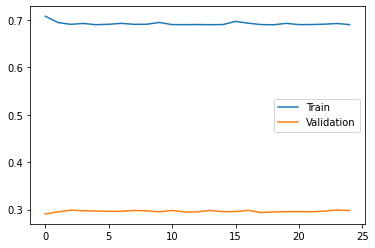

In [106]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label="Train")
plt.plot(validation_loss, label="Validation")
plt.legend()

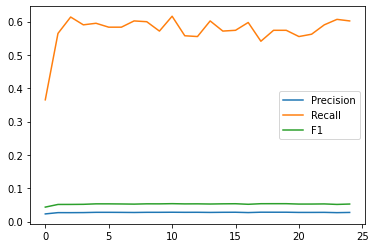

In [107]:
plt.plot(validation_prec, label="Precision")
plt.plot(validation_rec, label="Recall")
plt.plot(validation_f1, label="F1")
plt.legend()